In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlptools.io.read import read_from_format

all_scf_dirs = glob("/Users/y1u0d2/desktop/Lab/data/qe_data/SiO2/atoms/*")
# path2scf = "/Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-559091/result"
# all_scf_dirs.extend(glob(f'{path2scf}/scf*'))

# path2scf = "/Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-546794/result"
# all_scf_dirs.extend(glob(f'{path2scf}/scf*'))

# path2scf = "/Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-6945/result"
# all_scf_dirs.extend(glob(f'{path2scf}/scf*'))

path2scf = "/Users/y1u0d2/desktop/Lab/result/qe/SiO2/mp-6947/result"
all_scf_dirs.extend(glob(f'{path2scf}/scf*'))

# path2scf = "/Users/y1u0d2/desktop/Lab/result/qe/SiO2/amorphous/result_sq"
# all_scf_dirs.extend(glob(f'{path2scf}/scf*'))


print(f"Number of directories: {len(all_scf_dirs)}")

Number of directories: 44847


In [30]:
# import os

# for scf_dir in all_scf_dirs:
#     if os.path.exists(os.path.join(scf_dir, "atoms.pkl")):
#         # remove atoms.pkl
#         os.remove(os.path.join(scf_dir, "atoms.pkl"))

In [2]:
import re
import os
import pickle
import shutil


def get_mpid_from_path(path):
    match = re.search(r"mp-\d+", path)
    if match:
        result = match.group(0)
    elif "amorphous" in path.split("/"):
        result = "amorphous"
    else:
        result = None
    return result

all_atoms = []
len_scf_dirs = len(all_scf_dirs)
for i, path in enumerate(all_scf_dirs[:20]):
    # show progress
    if i % 100 == 0:
        print(f"{i}/{len_scf_dirs}")
    mpid = get_mpid_from_path(path)
    try:
        if os.path.exists(f"{path}/atoms.pkl"):
            print(f"Load pickle file: {path}")
            with open(f"{path}/atoms.pkl", 'rb') as f:
                atoms = pickle.load(f)
        else:
            atoms = read_from_format(
                path2target=path,
                format='espresso-in',
                structure_id=mpid
            )
            # save atoms as pickle
            print(f"Save pickle file: {path}")
            with open(f"{path}/atoms.pkl", 'wb') as f:
                pickle.dump(atoms, f)
        all_atoms.append(atoms)
    except Exception as e:
        print(f"[Error] {path}: {e}")
        # remove directory
        shutil.rmtree(path)
        print(f"[Remove dir]: {path}")
        continue

0/44847
Load pickle file: /Users/y1u0d2/desktop/Lab/data/qe_data/SiO2/atoms/00cc7d24-bd6f-4a10-8548-696c8ccb668b
Load pickle file: /Users/y1u0d2/desktop/Lab/data/qe_data/SiO2/atoms/0f6e931a-5a7f-4f09-a3de-ff1b5bfd404b
Load pickle file: /Users/y1u0d2/desktop/Lab/data/qe_data/SiO2/atoms/7bcfceda-de53-4272-89b7-48fc36e7389a
Load pickle file: /Users/y1u0d2/desktop/Lab/data/qe_data/SiO2/atoms/109949e6-c383-4273-bf87-159d750f7f4f
Load pickle file: /Users/y1u0d2/desktop/Lab/data/qe_data/SiO2/atoms/f4fee406-ffc5-4a01-af79-457289907c2d
Load pickle file: /Users/y1u0d2/desktop/Lab/data/qe_data/SiO2/atoms/b3cbea15-9427-4a1d-b55d-1ea275a88ec1
Load pickle file: /Users/y1u0d2/desktop/Lab/data/qe_data/SiO2/atoms/1c3a901a-5951-4c59-8828-667d0eb1a8f2
Load pickle file: /Users/y1u0d2/desktop/Lab/data/qe_data/SiO2/atoms/333bc75e-6114-4c09-b64e-d55226c1ca7d
Load pickle file: /Users/y1u0d2/desktop/Lab/data/qe_data/SiO2/atoms/fdac569d-2cc0-40c7-8858-b11e9948e0d8
Load pickle file: /Users/y1u0d2/desktop/Lab/dat

# Energy distribution

In [3]:
atoms_energy_dict = {
    "structure_id": [],
    "total_energy": [],
    "n_atoms": [],
    "volume": [],
    "energy_per_atom": [],
    "volume_per_atom": []
}
for atoms in all_atoms:
    atoms_energy_dict["structure_id"].append(atoms.structure_id)
    atoms_energy_dict["total_energy"].append(atoms.energy)
    atoms_energy_dict["n_atoms"].append(atoms.n_atoms)
    atoms_energy_dict["volume"].append(atoms.get_volume())
    atoms_energy_dict["energy_per_atom"].append(atoms.energy / atoms.n_atoms)
    atoms_energy_dict["volume_per_atom"].append(atoms.get_volume() / atoms.n_atoms)

In [4]:
atoms_energy_df = pd.DataFrame.from_dict(atoms_energy_dict)
atoms_energy_df.head()
# plot energy distribution

,structure_id,total_energy,n_atoms,volume,energy_per_atom,volume_per_atom
0,mp-6945,-7093.288332,12,202.692,-591.107361,16.891000
1,mp-6945,-6830.234306,12,54.783,-569.186192,4.565250
2,mp-6945,-7092.871869,12,192.388,-591.072656,16.032333
3,mp-559091,-7089.213072,12,161.935,-590.767756,13.494583
4,mp-546794,-27802.032266,48,312.534,-579.209006,6.511125


<Axes: xlabel='volume_per_atom', ylabel='energy_per_atom'>

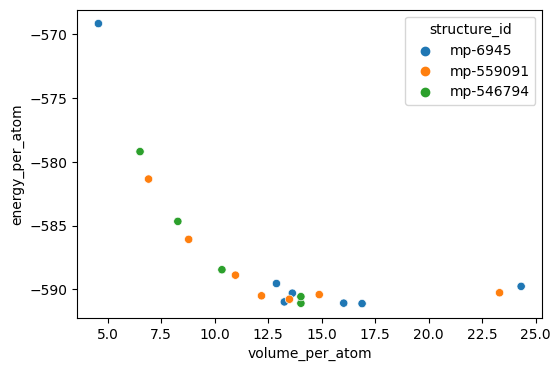

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=atoms_energy_df,
    x="volume_per_atom",
    y="energy_per_atom",
    hue="structure_id",
    ax=ax
)

# Force distribution

In [35]:
atoms_force_dict = {
    "structure_id": [],
    "force_x": [],
    "force_y": [],
    "force_z": [],
}
# sample atoms randomly
for atoms in np.random.choice(all_atoms, 10000):
    atoms_force_dict["structure_id"].extend(atoms.structure_id for _ in range(atoms.n_atoms))
    atoms_force_dict["force_x"].extend(atoms.force[:, 0])
    atoms_force_dict["force_y"].extend(atoms.force[:, 1])
    atoms_force_dict["force_z"].extend(atoms.force[:, 2])

<Axes: xlabel='force_x', ylabel='force_y'>

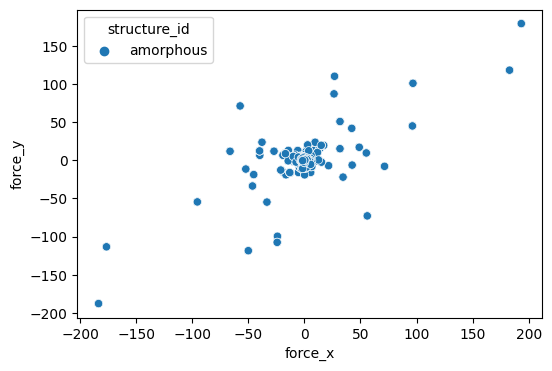

In [36]:
atoms_force_df = pd.DataFrame.from_dict(atoms_force_dict)

# plot force distribution
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=atoms_force_df,
    x="force_x",
    y="force_y",
    hue="structure_id",
    ax=ax
)

# RDF

In [15]:
rdf_mean_std_dict = {}

for atoms in np.random.choice(all_atoms, 10000):
    rdf = atoms.get_rdf_for_multiple_species()
    for key in rdf.keys():
        if key not in rdf_mean_std_dict.keys():
            rdf_mean_std_dict[key] = []
        rdf_mean_std_dict[key].append(rdf[key])

for key in rdf_mean_std_dict.keys():
    rdf_val_matrix = np.array(rdf_mean_std_dict[key])
    rdf_mean_std_dict[key] = {}
    rdf_mean_std_dict[key]["val"] = rdf_val_matrix
    rdf_mean_std_dict[key]["mean"] = np.mean(rdf_val_matrix, axis=0)
    rdf_mean_std_dict[key]["std"] = np.std(rdf_val_matrix, axis=0)

KeyboardInterrupt: 

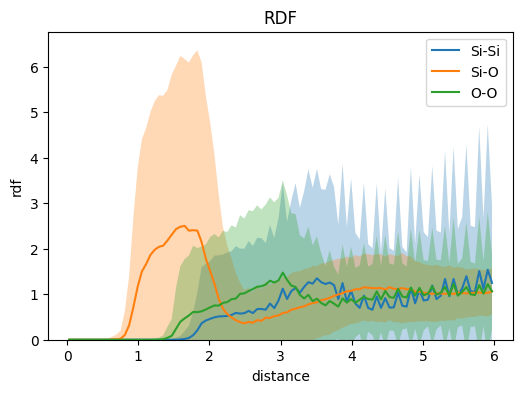

In [ ]:
# RDFを全て一緒にプロットする
fig, ax = plt.subplots(figsize=(6, 4))
for key in rdf_mean_std_dict.keys():
    if key == "distance":
        continue
    rdf_mean = rdf_mean_std_dict[key]["mean"]
    rdf_std = rdf_mean_std_dict[key]["std"]
    rdf_distance = rdf_mean_std_dict["distance"]["mean"]

    ax.plot(rdf_distance, rdf_mean, label=key)
    ax.fill_between(rdf_distance, rdf_mean-rdf_std, rdf_mean+rdf_std, alpha=0.3)

ax.set_title("RDF")
ax.set_xlabel("distance")
ax.set_ylabel("rdf")

ax.set_ylim(0,)
ax.legend()

/var/folders/hl/8xx4rtm50t7czkr79gggbqqr0000gr/T/ipykernel_29374/403849621.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


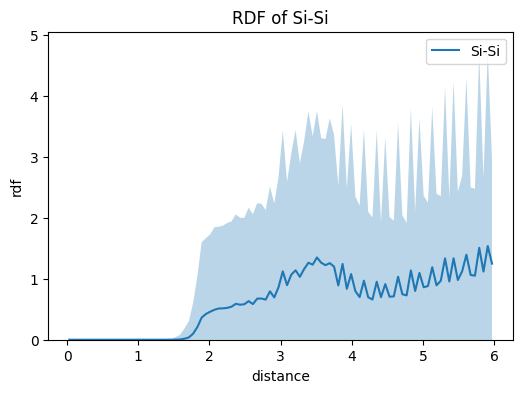

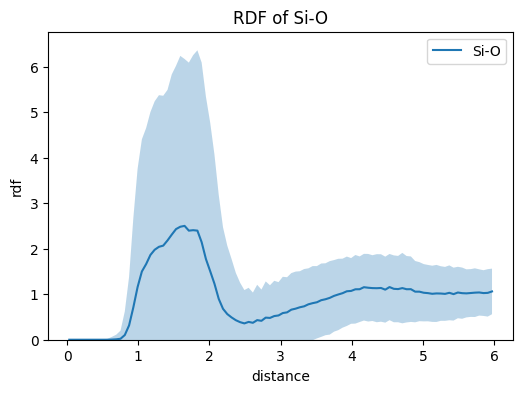

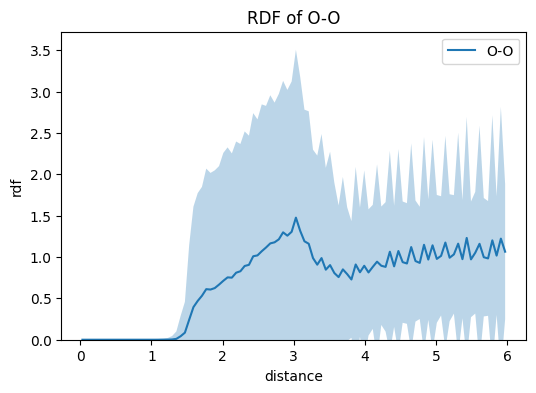

In [ ]:
# RDFを原子種ごとにプロットする
for key in rdf_mean_std_dict.keys():
    if key == "distance":
        continue
    rdf_mean = rdf_mean_std_dict[key]["mean"]
    rdf_std = rdf_mean_std_dict[key]["std"]
    rdf_distance = rdf_mean_std_dict["distance"]["mean"]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(rdf_distance, rdf_mean, label=key)
    ax.fill_between(rdf_distance, rdf_mean-rdf_std, rdf_mean+rdf_std, alpha=0.3)

    ax.set_title(f"RDF of {key}")
    ax.set_xlabel("distance")
    ax.set_ylabel("rdf")

    ax.set_ylim(0,)
    ax.legend()
    fig.show()

In [ ]:
atoms_energy_df.value_counts("structure_id")

structure_id
mp-559091    19067
mp-6945      15993
mp-546794     7697
mp-6947       2070
Name: count, dtype: int64